In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
x = abalone.data.features 
y = abalone.data.targets # for predicting abalone ages.
  
# metadata 
print(abalone.metadata) 
  
# variable information 
print(abalone.variables) 

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy 
from scipy.stats import pearsonr
import sklearn 
from sklearn import datasets, linear_model 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
#Combain the data to the same DataFrame and show the head
data_df = pd.concat([x, y], axis=1)
print("numbers:", len(data_df))
data_df.head(100)

numbers: 4177


Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
0    M   0.455     0.365   0.095        0.5140          0.2245   
1    M   0.350     0.265   0.090        0.2255          0.0995   
2    F   0.530     0.420   0.135        0.6770          0.2565   
3    M   0.440     0.365   0.125        0.5160          0.2155   
4    I   0.330     0.255   0.080        0.2050          0.0895   
..  ..     ...       ...     ...           ...             ...   
95   M   0.665     0.535   0.195        1.6060          0.5755   
96   M   0.535     0.435   0.150        0.7250          0.2690   
97   M   0.470     0.375   0.130        0.5230          0.2140   
98   M   0.470     0.370   0.130        0.5225          0.2010   
99   F   0.475     0.375   0.125        0.5785          0.2775   

    Viscera_weight  Shell_weight  Rings  
0           0.1010         0.150     15  
1           0.0485         0.070      7  
2           0.1415         0.210      9  
3           0.1140         0.155     10  
4           0.0395         0.055      7  
..             ...           ...    ...  
95          0.3880         0.480     14  
96          0.1385         0.250      9  
97          0.1320         0.145      8  
98          0.1330         0.165      7  
99          0.0850         0.155     10  

[100 rows x 9 columns]

In [4]:
sns.pairplot(data_df, hue='Sex', markers=["o", "s", "D"])

In [5]:
# # Replace values
# x['Sex'] = x['Sex'].replace({'M': 0, 'F': 1, 'I': 2})

# # Explicitly convert to integer type
# x['Sex'] = x['Sex'].astype(int)
# sex = x[['Sex']]  # second
# x = x[['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']]  # first

encoder = OneHotEncoder(sparse_output=False)    
x_encoded = encoder.fit_transform(x[['Sex']])
df_encoded = encoder.fit_transform(data_df[['Sex']])  
x_encoded_df = pd.DataFrame(x_encoded, columns=encoder.get_feature_names_out(['Sex']))
df_encoded_df = pd.DataFrame(df_encoded, columns=encoder.get_feature_names_out(['Sex']))
x = x.drop(columns=['Sex']).join(x_encoded_df)
data_df = data_df.drop(columns=['Sex']).join(df_encoded_df)


scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
df_scaled = scaler.fit_transform(data_df)
x = pd.DataFrame(x_scaled, columns=x.columns)
data_df = pd.DataFrame(df_scaled, columns=data_df.columns)
# x.head()
data_df.head()

# df = pd.DataFrame(x, columns=['Sex-M', 'Sex-F', 'Sex-I', 'Length', 'Diameter', 	'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight',	'Shell_weight', 'Rings'])

Length  Diameter    Height  Whole_weight  Shucked_weight  Viscera_weight  \
0 -0.574558 -0.432149 -1.064424     -0.641898       -0.607685       -0.726212   
1 -1.448986 -1.439929 -1.183978     -1.230277       -1.170910       -1.205221   
2  0.050033  0.122130 -0.107991     -0.309469       -0.463500       -0.356690   
3 -0.699476 -0.432149 -0.347099     -0.637819       -0.648238       -0.607600   
4 -1.615544 -1.540707 -1.423087     -1.272086       -1.215968       -1.287337   

   Shell_weight     Rings     Sex_F     Sex_I     Sex_M  
0     -0.638217  1.571544 -0.674834 -0.688018  1.316677  
1     -1.212987 -0.910013 -0.674834 -0.688018  1.316677  
2     -0.207139 -0.289624  1.481846 -0.688018 -0.759488  
3     -0.602294  0.020571 -0.674834 -0.688018  1.316677  
4     -1.320757 -0.910013 -0.674834  1.453451 -0.759488

In [6]:
# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile) for 'Height'
Q1 = x['Height'].quantile(0.20)
Q3 = x['Height'].quantile(0.80)
IQR = Q3 - Q1

# Step 2: Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Identify outliers
outliers = x[(x['Height'] < lower_bound) | (x['Height'] > upper_bound)]

# Print outliers
print("Outliers in 'Height':")
print(outliers)

# Step 4: Handling outliers by capping
# Remove infant whose height larger than upper bound, non-infant smaller than lower bound
x = x[~((x['Height'] > upper_bound) & (x['Sex_I'] == True))]
x = x[~((x['Height'] < lower_bound) & (x['Sex_I'] == False))]
x['Height'] = x['Height'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

Outliers in 'Height':
        Length  Diameter     Height  Whole_weight  Shucked_weight  \
1257 -0.782755 -0.684094  -3.335953     -0.817290       -0.688790   
1417  1.507413  1.583412   8.978125      2.816995        3.370932   
2051 -0.574558 -0.532927  23.683287     -0.478743       -0.123312   
3996 -1.740462 -1.792652  -3.335953     -1.416886       -1.360153   

      Viscera_weight  Shell_weight     Sex_F     Sex_I     Sex_M  
1257       -0.863071     -0.889679 -0.674834  1.453451 -0.759488  
1417        2.791088      1.962619 -0.674834 -0.688018  1.316677  
2051       -0.589352     -0.756763  1.481846 -0.688018 -0.759488  
3996       -1.387701      0.802301 -0.674834  1.453451 -0.759488  


In [7]:
# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile) for 'Height'
Q1 = data_df['Height'].quantile(0.20)
Q3 = data_df['Height'].quantile(0.80)
IQR = Q3 - Q1

# Step 2: Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Identify outliers
outliers = data_df[(data_df['Height'] < lower_bound) | (data_df['Height'] > upper_bound)]

# Print outliers
print("Outliers in 'Height':")
print(outliers)

# Step 4: Handling outliers by capping
# Remove infant whose height larger than upper bound, non-infant smaller than lower bound
data_df = data_df[~((data_df['Height'] > upper_bound) & (data_df['Sex_I'] == True))]
data_df = data_df[~((data_df['Height'] < lower_bound) & (data_df['Sex_I'] == False))]
data_df['Height'] = data_df['Height'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

Outliers in 'Height':
        Length  Diameter     Height  Whole_weight  Shucked_weight  \
1257 -0.782755 -0.684094  -3.335953     -0.817290       -0.688790   
1417  1.507413  1.583412   8.978125      2.816995        3.370932   
2051 -0.574558 -0.532927  23.683287     -0.478743       -0.123312   
3996 -1.740462 -1.792652  -3.335953     -1.416886       -1.360153   

      Viscera_weight  Shell_weight     Rings     Sex_F     Sex_I     Sex_M  
1257       -0.863071     -0.889679 -0.599818 -0.674834  1.453451 -0.759488  
1417        2.791088      1.962619  0.020571 -0.674834 -0.688018  1.316677  
2051       -0.589352     -0.756763 -0.599818  1.481846 -0.688018 -0.759488  
3996       -1.387701      0.802301 -1.220208 -0.674834  1.453451 -0.759488  


In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4177 non-null   float64
 1   Diameter        4177 non-null   float64
 2   Height          4177 non-null   float64
 3   Whole_weight    4177 non-null   float64
 4   Shucked_weight  4177 non-null   float64
 5   Viscera_weight  4177 non-null   float64
 6   Shell_weight    4177 non-null   float64
 7   Rings           4177 non-null   float64
 8   Sex_F           4177 non-null   float64
 9   Sex_I           4177 non-null   float64
 10  Sex_M           4177 non-null   float64
dtypes: float64(11)
memory usage: 359.1 KB


In [9]:
data_df.describe() # describe

Length      Diameter       Height  Whole_weight  Shucked_weight  \
count  4.177000e+03  4.177000e+03  4177.000000  4.177000e+03    4.177000e+03   
mean  -5.834718e-16 -3.027929e-16    -0.006211  9.185853e-17   -1.020650e-17   
std    1.000120e+00  1.000120e+00     0.923032  1.000120e+00    1.000120e+00   
min   -3.739154e+00 -3.556267e+00    -3.335953 -1.686092e+00   -1.614731e+00   
25%   -6.161975e-01 -5.833158e-01    -0.586208 -7.897577e-01   -7.811585e-01   
50%    1.749513e-01  1.725193e-01     0.011563 -5.963767e-02   -1.052891e-01   
75%    7.579031e-01  7.267984e-01     0.609334  6.613049e-01    6.426730e-01   
max    2.423480e+00  2.440025e+00     3.359080  4.072271e+00    5.085388e+00   

       Viscera_weight  Shell_weight         Rings         Sex_F         Sex_I  \
count    4.177000e+03  4.177000e+03  4.177000e+03  4.177000e+03  4.177000e+03   
mean     2.704723e-16  2.976897e-16  8.505419e-17 -4.252710e-17 -7.144552e-17   
std      1.000120e+00  1.000120e+00  1.000120e+00  1.000120e+00  1.000120e+00   
min     -1.643173e+00 -1.705134e+00 -2.771180e+00 -6.748338e-01 -6.880179e-01   
25%     -7.946415e-01 -7.819095e-01 -5.998184e-01 -6.748338e-01 -6.880179e-01   
50%     -8.753202e-02 -3.470794e-02 -2.896238e-01 -6.748338e-01 -6.880179e-01   
75%      6.606355e-01  6.478319e-01  3.307653e-01  1.481846e+00  1.453451e+00   
max      5.286500e+00  5.504642e+00  5.914268e+00  1.481846e+00  1.453451e+00   

              Sex_M  
count  4.177000e+03  
mean   1.169495e-17  
std    1.000120e+00  
min   -7.594876e-01  
25%   -7.594876e-01  
50%   -7.594876e-01  
75%    1.316677e+00  
max    1.316677e+00

In [10]:
data_mean = data_df.iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(3,4), sharex=False, 
sharey=False, fontsize=14, figsize=(15,25));

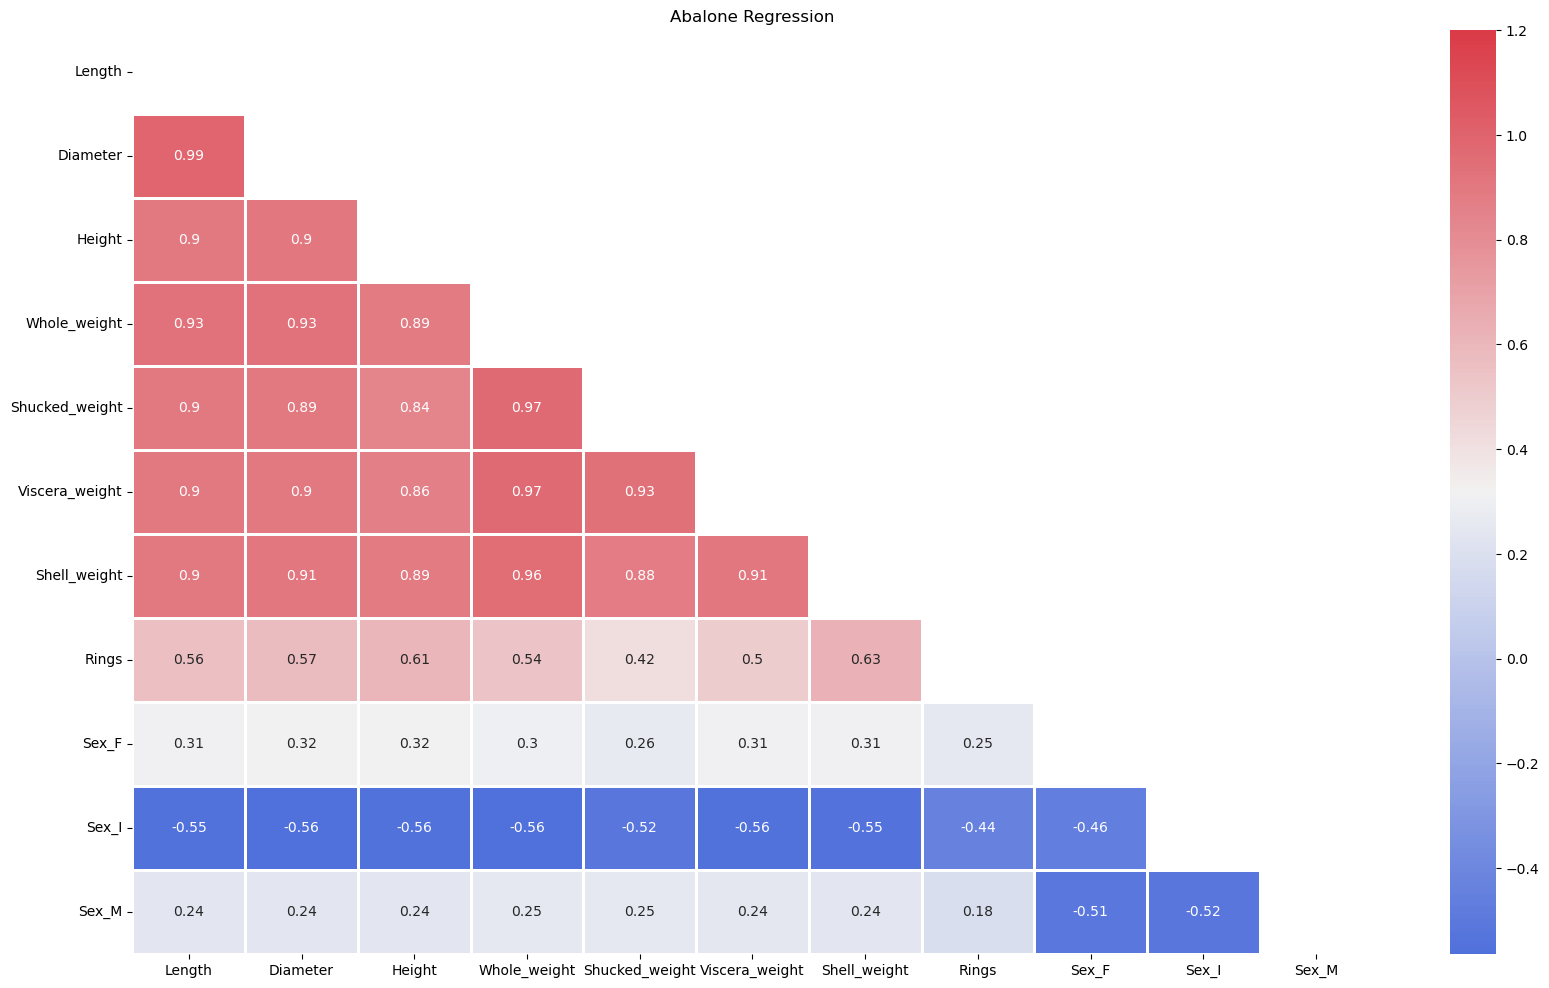

In [11]:
corrMatt = data_df.corr(numeric_only=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 12))
plt.title('Abalone Regression')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, 
ax=ax, annot=True, fmt='.2g', linewidths=1);

In [12]:
# data_df['volume'] = np.pi * data_df['Length'] * data_df['Diameter'] * data_df['Height'] / 6 / 1000
data_df = data_df.drop(columns=['Length'])
x = x.drop(columns=['Length'])
# data_df = data_df.drop(columns=['Diameter']) # Reduce the strong importance of the columns
# data_df = data_df.drop(columns=['Height'])
print(data_df)

      Diameter    Height  Whole_weight  Shucked_weight  Viscera_weight  \
0    -0.432149 -1.064424     -0.641898       -0.607685       -0.726212   
1    -1.439929 -1.183978     -1.230277       -1.170910       -1.205221   
2     0.122130 -0.107991     -0.309469       -0.463500       -0.356690   
3    -0.432149 -0.347099     -0.637819       -0.648238       -0.607600   
4    -1.540707 -1.423087     -1.272086       -1.215968       -1.287337   
...        ...       ...           ...             ...             ...   
4172  0.424464  0.609334      0.118813        0.047908        0.532900   
4173  0.323686 -0.107991      0.279929        0.358808        0.309362   
4174  0.676409  1.565767      0.708212        0.748559        0.975413   
4175  0.777187  0.250672      0.541998        0.773341        0.733627   
4176  1.482634  1.326659      2.283681        2.640993        1.787449   

      Shell_weight     Rings     Sex_F     Sex_I     Sex_M  
0        -0.638217  1.571544 -0.674834 -0.688018  

In [13]:
corrMatt = data_df.corr(numeric_only=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 12))
plt.title('Abalone Regression')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, 
ax=ax, annot=True, fmt='.2g', linewidths=1);

In [14]:
# Regression function
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

ys = y.values.ravel()

def regression(model, x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
    # train the model
    model.fit(x_train, y_train)
    print("Accuracy:", model.score(x_test, y_test) * 100, "%")
    
    y_pred = model.predict(x)
    # calculate MSE
    mse = mean_squared_error(y, y_pred)
    print("Mean Squared Error:", mse)

In [15]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=True)

regression(lr, x, y)

# cross-validation
n_folds = 5
scores = cross_val_score(lr, x, y, cv=5)
print(scores)
avg = (100 * np.mean(scores), 100 * np.std(scores)/np.sqrt(scores.shape[0]))
print("Average score and standard deviation: (%.4f +- %.5f)%%" %avg)

Accuracy: 54.46702671774861 %
Mean Squared Error: 4.750239010214096
[0.43739316 0.20245783 0.5344552  0.52327818 0.45971255]
Average score and standard deviation: (43.1459 +- 5.37825)%


In [21]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(criterion="squared_error", max_depth=5)

regression(dtr, x, y)

# cross-validation
n_folds = 5
scores = cross_val_score(dtr, x, y, cv=5)
print(scores)
avg = (100 * np.mean(scores), 100 * np.std(scores)/np.sqrt(scores.shape[0]))
print("Average score and standard deviation: (%.4f +- %.5f)%%" %avg)

Accuracy: 49.43343245878403 %
Mean Squared Error: 4.7989532838197855
[0.34606544 0.16049562 0.44646469 0.46690001 0.43866657]
Average score and standard deviation: (37.1718 +- 5.07550)%


In [20]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', gamma='scale', C=100, epsilon=0.5)

regression(svr, x, ys)

# cross-validation
n_folds = 5
scores = cross_val_score(svr, x, ys, cv=5)
print(scores)
avg = (100 * np.mean(scores), 100 * np.std(scores)/np.sqrt(scores.shape[0]))
print("Average score and standard deviation: (%.4f +- %.5f)%%" %avg)

Accuracy: 54.918458451231636 %
Mean Squared Error: 4.180109948179528
[0.40587553 0.48225632 0.50918228 0.5771453  0.55571139]
Average score and standard deviation: (50.6034 +- 2.69308)%


In [19]:
from sklearn.neural_network import MLPRegressor

xs_train, xs_test, ys_train, ys_test = train_test_split(x, ys, test_size=0.25, random_state=42)
mlp_reg = MLPRegressor(hidden_layer_sizes=(64, 32, 16, 8), max_iter=500, learning_rate_init=0.0015, batch_size=80).fit(xs_train, ys_train)

regressor_score = mlp_reg.score(xs_test, ys_test)
print('The regression accuracy score of MLP is {:03.2f}'.format(regressor_score))

# cross-validation
n_folds = 5
scores = cross_val_score(mlp_reg, x, ys, cv=5)
print(scores)
avg = (100 * np.mean(scores), 100 * np.std(scores)/np.sqrt(scores.shape[0]))
print("Average score and standard deviation: (%.4f +- %.5f)%%" %avg)

The regression accuracy score of MLP is 0.58
[0.45609319 0.46042469 0.53118365 0.53417355 0.54402112]
Average score and standard deviation: (50.5179 +- 1.72488)%


In [22]:
# Setting up k for k-fold cross-validation
k = 5

# Initializing dictionary to store cross-validation results
cv_results = {
    "Model": ["Linear Regression", "Decision Tree", "SVM", "Neural Network"],
    "Mean Cross-Validation Score": [],
    "Standard Deviation": []
}

# Running k-fold cross-validation for each model
for model, name in zip([lr, dtr, svr, mlp_reg], cv_results["Model"]):
    scores = cross_val_score(model, x_scaled, ys, cv=k, scoring='r2')
    cv_results["Mean Cross-Validation Score"].append(scores.mean())
    cv_results["Standard Deviation"].append(scores.std())

# Converting results to DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Plotting the cross-validation results
plt.figure(figsize=(10, 6))
plt.bar(cv_results_df["Model"], cv_results_df["Mean Cross-Validation Score"], yerr=cv_results_df["Standard Deviation"])
plt.title("Model Performance Comparison (k-Fold Cross-Validation)")
plt.xlabel("Model")
plt.ylabel("Mean R-squared Score")
plt.show()